In [ ]:
#1. Revisiting MLP of Assignment1

#Reference. https://github.com/Justin-A/DeepLearning101/blob/master/2-1_MNIST_MLP.ipynb

In [ ]:
# connecting Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
!mkdir intro-dl
%cd /content/drive/MyDrive/intro-dl/

/content/drive/MyDrive/intro-dl


In [ ]:
!unzip -qq //content/drive/MyDrive/archive.zip -d /content/drive/MyDrive/intro-dl

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [ ]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

BATCH_SIZE = 32
EPOCHS = 10

Using PyTorch version: 2.3.0+cu121  Device: cpu


In [ ]:
train_dataset = datasets.MNIST(root = "../data/MNIST",
                               train = True,
                               download = True,
                               transform = transforms.ToTensor())

test_dataset = datasets.MNIST(root = "../data/MNIST",
                              train = False,
                              transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 34230186.96it/s]


Extracting ../data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1308401.04it/s]

Extracting ../data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9534255.34it/s]


Extracting ../data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4331634.55it/s]

Extracting ../data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw



In [ ]:
#(1) Using torchvision.transforms
#Reference. https://www.kaggle.com/code/eduardignatev/madmo-pro-homework-02#Load-Data

## Data transformation only for train data
transform_train = transforms.Compose([
    transforms.Resize(size=(256, 256)), ## Resizing the data into (256, 256)
    transforms.RandomRotation(30), ## 30 degree rotation (data augmentation)
    transforms.ToTensor(), ## To 'Pytorch Tensor' -> Pytorch Deep Learning Models like CNN (we'll deal with it later on) get only tensor as an input
])

## Data transformation only for validation (here, it works like the 'test' data...) data
transform_val = transforms.Compose([
    transforms.Resize(size=(256, 256)), ## Resizing the data into (256, 256)
    transforms.ToTensor() ## To 'Pytorch Tensor'
])

## Please note that the data augmentation technique is not usually implemented to validation/test dataset
## This is why we split transform_train and transform_val -- transform_val does not need the data augmentation technique
## transforms.RandomRotation(30), ## 30 degree rotation (data augmentation)


train_data = datasets.ImageFolder(root='/content/drive/MyDrive/intro-dl/afhq/train', transform=transform_train)
## Pytorch function datasets.ImageFolder organizes the data in root directory (here, '/content/drive/MyDrive/intro-dl/afhq/train')
## and applies transform_train as defined above.
val_data = datasets.ImageFolder(root='/content/drive/MyDrive/intro-dl/afhq/val', transform=transform_val)
## Pytorch function datasets.ImageFolder organizes the data in root directory (here, '/content/drive/MyDrive/intro-dl/afhq/val')
## and applies transform_val as defined above.

train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle = True)
## Pytorch function DataLoader organizes the 'shuffled' (shuffle = True) data in train_data as defined above with the batch size of 16.
val_loader = torch.utils.data.DataLoader(val_data, batch_size=16, shuffle = True)
## Pytorch function DataLoader organizes the 'shuffled' (shuffle = True) data in val_data as defined above with the batch size of 16.

In [ ]:
train_data.class_to_idx ## It automatically catches the classes in train_data
## -> check it by yourself!: see /content/drive/MyDrive/intro-dl/afhq/val directory in your Google Drive

{'cat': 0, 'dog': 1, 'wild': 2}

In [ ]:
## brings the next images and labels
dataiter = iter(train_loader)
images, labels = next(dataiter)

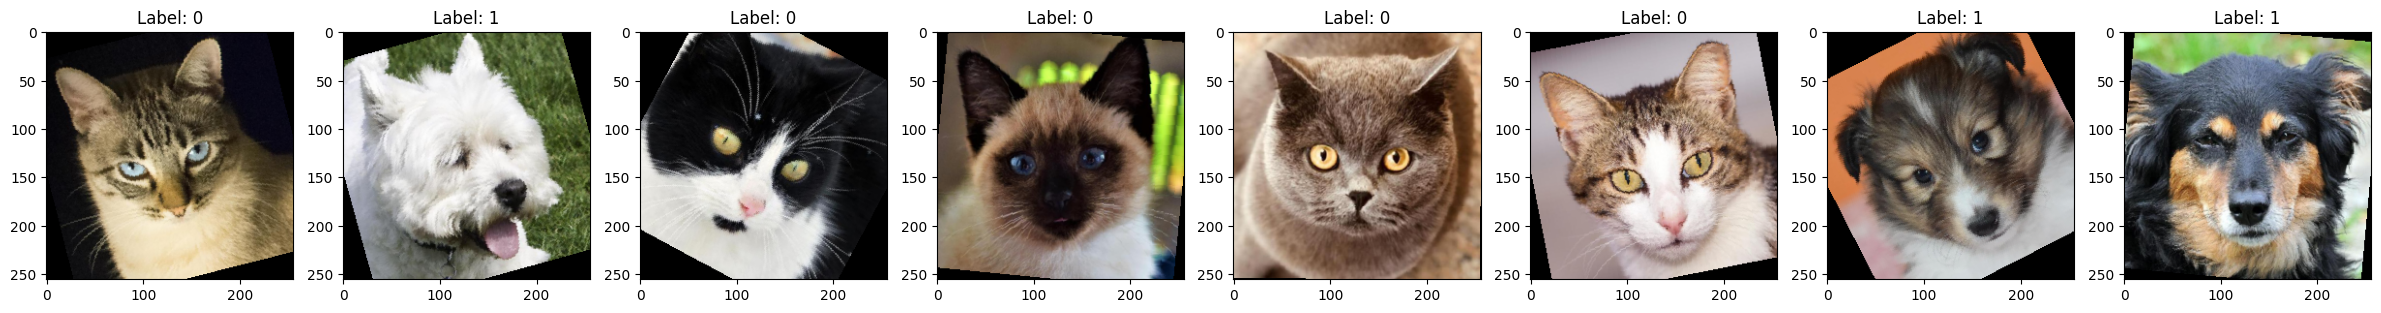

In [ ]:
def show_imgs(imgs, labels, preds=None):
    f, axes= plt.subplots(1, 8, figsize=(30,5))
    for i, axis in enumerate(axes):
        axes[i].imshow(np.squeeze(np.transpose(imgs[i].numpy(), (1, 2, 0))), cmap='gray')
        axes[i].set_title(f'Label: {labels[i].numpy()}')
        if preds != None:
            axes[i].set_xlabel(f'Pred: {np.argmax(preds[i].numpy())}')
    plt.show()

show_imgs(images, labels)

## shows the sample train_data
## 30 degree rotation!

In [ ]:
#(2) Making a customized datasets and dataloader

In [ ]:
## We'll use the library 'os' -- please revisit Assignment1
import os

In [ ]:
train_cat = os.listdir('/content/drive/MyDrive/intro-dl/afhq/train/cat')
train_dog = os.listdir('/content/drive/MyDrive/intro-dl/afhq/train/dog')
train_wild = os.listdir('/content/drive/MyDrive/intro-dl/afhq/train/wild')

In [ ]:
# WARNING: DO NOT RUN THIS CODE. IT TAKES TOO LONG TIME TO GET THE RESULT.

train_cat_image = []
train_dog_image = []
train_wild_image = []

train_cat_target = []
train_dog_target = []
train_wild_target = []

for i in range(len(train_cat)):
  image = plt.imread(os.path.join('/content/drive/MyDrive/intro-dl/afhq/train/cat', train_cat[i]))
  train_cat_image.append(image)
  train_cat_target.append(0)

for i in range(len(train_dog)):
  image = plt.imread(os.path.join('/content/drive/MyDrive/intro-dl/afhq/train/dog', train_dog[i]))
  train_dog_image.append(image)
  train_dog_target.append(1)

for i in range(len(train_wild)):
  image = plt.imread(os.path.join('/content/drive/MyDrive/intro-dl/afhq/train/wild', train_wild[i]))
  train_wild_image.append(image)
  train_wild_target.append(2)

In [ ]:
##Question 1. Explain os.path.join function.

#Your Answer.파일 경로나 디렉터리 경로를 결합할 때 사용되는 함수로, 운영 체제에 구애받지 않고 일관된 방식으로 파일 및 디렉터리 경로를 다룰 수 있다는 장점이 있다.

In [ ]:
#2. Backpropagation and PyTorch Autograd
##https://kingnamji.tistory.com/44

In [ ]:
import torch

In [ ]:
## requires_grad = True: it saves the gradient
w = torch.tensor(3.0, requires_grad = True) #3.0의 의미: w의 초기값

In [ ]:
y = w**3 + 10

In [ ]:
## backward() calculates the derivative
y.backward()
#주어진 스칼라 값 y에 대해, 모든 연산의 그래디언트를 계산하고, 이를 각 텐서의 .grad 속성에 저장 -> 다음 문장에서 w.grad가 사용되는 이유

In [ ]:
print(f'Differentiating y by w: {w.grad}')
## check it by yourself!! dy/dw = 3*w^2 ..., so 27.(기본적으로 w=3으로 설정해놨기 때문에)

Differentiating y by w: 27.0


In [ ]:
## Another example with the loss fuction
import torch
import torch.nn as nn

In [ ]:
x = torch.ones(5)  # input
y = torch.zeros(3)  # output

w = torch.randn(5, 3, requires_grad=True) # weight
b = torch.randn(3, requires_grad=True) # bias
z = torch.matmul(x, w) + b # z = wx + b
loss_fn = nn.MSELoss() # loss function

In [ ]:
loss = loss_fn(z, y)

loss.backward()

In [ ]:
print(f'Differentiating loss by w :\n {w.grad}')
print(f'Differentiating loss by b : {b.grad}')

Differentiating loss by w :
 tensor([[-1.2415, -0.1889,  1.7645],
        [-1.2415, -0.1889,  1.7645],
        [-1.2415, -0.1889,  1.7645],
        [-1.2415, -0.1889,  1.7645],
        [-1.2415, -0.1889,  1.7645]])
Differentiating loss by b : tensor([-1.2415, -0.1889,  1.7645])


In [ ]:
#Question 2. PyTorch Autograd and DataLoader
#Read the following document and summarize it.
##https://velog.io/@euisuk-chung/%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98-%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98-%EA%B8%B0%EC%B4%88-%EC%9A%94%EC%86%8C-Autograd%EB%9E%80

In [ ]:
#3. Vanishing Gradient Problem

# Although we usually build DL models based on PyTorch,we sometimes need to use TensorFlow upon your colleagues' requests.
## Let's take a look at the vanishing gradient problem w/ Tensorflow
#Reference. https://github.com/bhattbhavesh91/vanishing-gradient-problem/blob/master/vanishing-gradient-notebook.ipynb

In [3]:
import matplotlib.pyplot as plt #그래프를 그리기 위한 라이브러리 matplotlib.pyplot 불러오기
import numpy as np #수치계산을 위한 라이브러리 numpy 불러오기
import pandas as pd #데이터분석을 위한 라이브러리 panda 불러오기
import tensorflow as tf #딥러닝 및 머신러닝 모델 구축을 위한 라이브러리 tensorflow 불러오기
import warnings #경고 메세지를 제어하는 라이브러리 warnings 불러오기: 경고 메세지 무시하기
from matplotlib.colors import ListedColormap #색상맵 생성
from mlxtend.plotting import plot_decision_regions #결정경계(regions를 구분하는 경계)를 시각화하는 함수
from pylab import rcParams #런타임 설정 제어
from sklearn.datasets import make_circles, make_moons #샘플 데이터셋 생성
from sklearn.model_selection import train_test_split #전체 data set을 train set과 test set으로 나누는 함수
from tensorflow.keras.layers import Dense #dense layer 만들기
from tensorflow.keras.models import Sequential #순차 모델 만들기

In [ ]:
np.set_printoptions(suppress=True) #소수점 표기 방식 변경: 1.23^e-2 -> 0.0123
zero_one_colourmap = ListedColormap(('white', 'red')) #색상맵 정의: 빨간색과 흰색 사용
rcParams['figure.figsize'] = 14, 7 #plot 크기 설정
rcParams['axes.facecolor'] = '#383838' #plot 배경색 설정

In [ ]:
#make_circles: 원형 데이터셋 생성 -> 두 개의 동심원을 만들어서 분류문제에 자주 사용하는 데이터셋
X, y = make_circles(n_samples = 1000, #1000개의 데이터 생성
                    factor=0.85, #두 동심원 간 반지름의 길이 비율 설정
                    random_state=2021, #random seed 설정
                    noise=0.1) #노이즈양 설정: 노이즈값이 커질수록 데이터가 더 퍼지게 됨

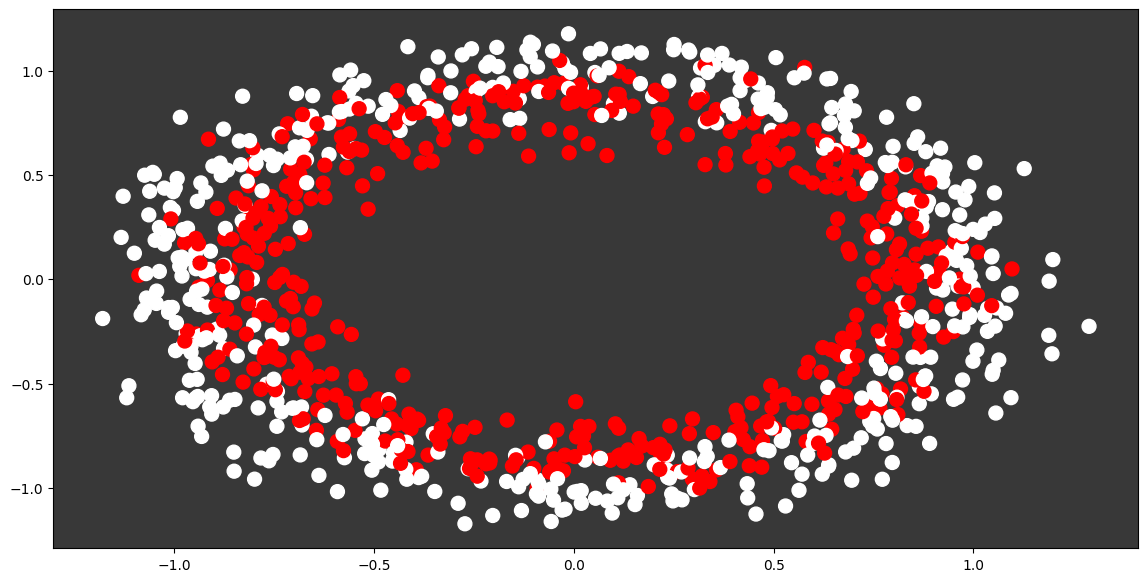

In [ ]:
plt.scatter(X[:,0],X[:,1], #각 데이터의 x, y 좌표에 대해
            c=y, #색상을 y값에 따라 설정
            s=100, #데이터 포인트의 크기 설정
            cmap = zero_one_colourmap) #색상맵 설정
plt.show() #plot 출력

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.33,#전체 데이터 중 33%의 데이터가 test에, 나머지 67%가 train에 사용됨
                                                    random_state=42) #random seed 설정

In [ ]:
#MLP 설계
def get_model(inp_activation):
  model = Sequential() #순차 모델 생성: 각 layer가 순서대로 쌓여간다는 뜻
  model.add(Dense(10,input_dim=2, activation=inp_activation)) #1st hidden-layer: 뉴런의 개수 10개
  model.add(Dense(10, activation = inp_activation))
  model.add(Dense(10, activation = inp_activation))
  model.add(Dense(10, activation = inp_activation))
  model.add(Dense(10, activation = inp_activation))
  model.add(Dense(10, activation = inp_activation))
  model.add(Dense(10, activation = inp_activation))
  model.add(Dense(10, activation = inp_activation))
  model.add(Dense(10, activation = inp_activation))
  model.add(Dense(10, activation = inp_activation))
  model.add(Dense(10, activation = inp_activation))
  model.add(Dense(1, activation="sigmoid")) #output layer: sigmoid 함수를 activation function으로 사용
  model.compile(loss='binary_crossentropy', #loss funcion으로 이진 분류 문제에서 사용되는 binary crossentropy 사용
                optimizer='adam', #optimizer로 Adam 이용: Momentum+ RMSprop
                metrics=['accuracy']) #모델의 성능: accuracy로 판단
  return model

In [ ]:
#weight update, 학습 진행 모니터링하는 함수 정의
def change_in_weight_gradient(old_weight, new_weight, learning_rate):
  gradient = (old_weight - new_weight)/ learning_rate
  pct_change_weight = abs(100*(old_weight - new_weight)/ old_weight) #weight의 변화량을 백분율로 계산
  return gradient, pct_change_weight

In [ ]:
#Sigmoid Model
sigmoid_model = get_model("sigmoid") #activation function으로 sigmoid를 사용하는 모델

In [ ]:
sigmoid_model.summary() #model 내용 summary 출력

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                30        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
 dense_4 (Dense)             (None, 10)                110       
                                                                 
 dense_5 (Dense)             (None, 10)                110       
                                                                 
 dense_6 (Dense)             (None, 10)                1

In [ ]:
#get_weights(): weight, bias 출력 -> 첫번째 층의 첫번째 뉴런의 weight 출력
sigmoid_model_first_layer_weights = sigmoid_model.get_weights()[0][0]

In [ ]:
#첫번째 층의 첫번째 뉴런의 weight 출력
sigmoid_model_first_layer_weights

array([ 0.5974342 ,  0.5223611 ,  0.4097579 , -0.35568416, -0.50672954,
        0.19290763,  0.447398  , -0.40421456, -0.66148114, -0.05909395],
      dtype=float32)

In [ ]:
#sigmoid_model.fit(): sigmoid model을 이용해서 훈련하는 과정에서 구해지는 loss, accuracy 계산 및 저장
sigmoid_history = sigmoid_model.fit(X_train, y_train, epochs = 1,
                            validation_data = (X_test, y_test)) #성능평가 시 사용

21/21 [==============================] - 4s 32ms/step - loss: 0.7088 - accuracy: 0.5119 - val_loss: 0.7128 - val_accuracy: 0.4758


In [ ]:
#sigmoid 의 첫 번째 layer의 weight가 업데이트된 후의 값
sigmoid_model_first_layer_weights_updated = sigmoid_model.get_weights()[0][0]

In [ ]:
sigmoid_model_first_layer_weights_updated

array([ 0.59743357,  0.52236086,  0.40975776, -0.35568455, -0.5067294 ,
        0.19290763,  0.44739798, -0.40421525, -0.66148067, -0.05909378],
      dtype=float32)

In [ ]:
s_gradient, s_weight_change = change_in_weight_gradient(sigmoid_model_first_layer_weights,
                                                        sigmoid_model_first_layer_weights_updated,
                                                        sigmoid_model.optimizer.get_config()["learning_rate"])

In [ ]:
#weight update를 위해 계산된 gradient값
s_gradient

array([ 0.00065565,  0.00023842,  0.00014901,  0.00038743, -0.00011921,
        0.        ,  0.0000298 ,  0.00068545, -0.00047684, -0.00017509],
      dtype=float32)

In [ ]:
#weight 변화량에 대한 백분율 변화
s_weight_change

array([0.00010974, 0.00004564, 0.00003637, 0.00010893, 0.00002353,
       0.        , 0.00000666, 0.00016958, 0.00007209, 0.00029629],
      dtype=float32)

In [ ]:
#ReLU Model: activation function으로 relu 사용
activation_model = get_model("relu")

In [ ]:
#get_weights(): weight, bias 출력 -> 첫번째 층의 첫번째 뉴런의 weight 출력
activation_model_old_first_layer_weight = activation_model.get_weights()[0][0]
activation_model_old_first_layer_weight

array([ 0.5444378 , -0.56336004, -0.34767845,  0.31670254, -0.40029392,
       -0.02114105, -0.38847727, -0.16244894,  0.5589053 ,  0.04647332],
      dtype=float32)

In [ ]:
#activation_model.fit(): relu model을 이용해서 훈련하는 과정에서 구해지는 loss, accuracy 계산 및 저장
activation_history = activation_model.fit(X_train, y_train, epochs = 1,
                                          validation_data = (X_test, y_test))

21/21 [==============================] - 3s 17ms/step - loss: 0.6929 - accuracy: 0.5045 - val_loss: 0.6924 - val_accuracy: 0.5606


In [ ]:
#Relu 의 첫 번째 layer의 weight가 업데이트된 후의 값
activation_model_updated_first_layer_weight = activation_model.get_weights()[0][0]

In [ ]:
activation_model_updated_first_layer_weight

array([ 0.5410586 , -0.5591492 , -0.3495264 ,  0.31177604, -0.40482834,
       -0.03131431, -0.38952577, -0.16856961,  0.5658436 ,  0.04592966],
      dtype=float32)

In [ ]:
relu_gradient, relu_weight_change = change_in_weight_gradient(activation_model_old_first_layer_weight,
                                                              activation_model_updated_first_layer_weight,
                                                              activation_model.optimizer.get_config()["learning_rate"])

In [ ]:
#weight update를 위해 계산된 gradient값
relu_gradient

array([ 3.3792255 , -4.2108297 ,  1.8479525 ,  4.9265027 ,  4.5344234 ,
       10.173261  ,  1.0485053 ,  6.1206665 , -6.938278  ,  0.54366887],
      dtype=float32)

In [ ]:
#weight 변화량에 대한 백분율 변화
relu_weight_change

array([ 0.62068164,  0.74744916,  0.53151196,  1.5555614 ,  1.1327735 ,
       48.120884  ,  0.26990134,  3.767748  ,  1.241405  ,  1.1698514 ],
      dtype=float32)

In [ ]:
#Question 3.
#Check out this YouTube and write a line-by-line explanation of the code above -- ChatGPT allowed.
#https://youtube.com/watch?v=wTyZqtJyp5g

In [ ]:
#4. Regression
##Reference. https://www.geeksforgeeks.org/linear-regression-python-implementation/

In [1]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model, metrics

In [14]:
data_url = "http://lib.stat.cmu.edu/datasets/boston" ## Loading Boston Housing Dataset -- a famous dataset for linear regression
raw_df = pd.read_csv(data_url, sep="\s+",
           skiprows=22, header=None)

In [15]:
X = np.hstack([raw_df.values[::2, :],  #짝수 인덱스의 행(0으로부터 +2씩)만 선택
        raw_df.values[1::2, :2]]) #홀수 인덱스(1로부터 +2씩)의 행만 선택, 첫 두 개의 열만 선택
y = raw_df.values[1::2, 2] #홀수 인덱스의 행만 선택, 두 번째의 열

In [6]:
X

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
        4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
        9.1400e+00],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
        4.0300e+00],
       ...,
       [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        5.6400e+00],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
        6.4800e+00],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        7.8800e+00]])

In [7]:
y

array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9, 15. ,
       18.9, 21.7, 20.4, 18.2, 19.9, 23.1, 17.5, 20.2, 18.2, 13.6, 19.6,
       15.2, 14.5, 15.6, 13.9, 16.6, 14.8, 18.4, 21. , 12.7, 14.5, 13.2,
       13.1, 13.5, 18.9, 20. , 21. , 24.7, 30.8, 34.9, 26.6, 25.3, 24.7,
       21.2, 19.3, 20. , 16.6, 14.4, 19.4, 19.7, 20.5, 25. , 23.4, 18.9,
       35.4, 24.7, 31.6, 23.3, 19.6, 18.7, 16. , 22.2, 25. , 33. , 23.5,
       19.4, 22. , 17.4, 20.9, 24.2, 21.7, 22.8, 23.4, 24.1, 21.4, 20. ,
       20.8, 21.2, 20.3, 28. , 23.9, 24.8, 22.9, 23.9, 26.6, 22.5, 22.2,
       23.6, 28.7, 22.6, 22. , 22.9, 25. , 20.6, 28.4, 21.4, 38.7, 43.8,
       33.2, 27.5, 26.5, 18.6, 19.3, 20.1, 19.5, 19.5, 20.4, 19.8, 19.4,
       21.7, 22.8, 18.8, 18.7, 18.5, 18.3, 21.2, 19.2, 20.4, 19.3, 22. ,
       20.3, 20.5, 17.3, 18.8, 21.4, 15.7, 16.2, 18. , 14.3, 19.2, 19.6,
       23. , 18.4, 15.6, 18.1, 17.4, 17.1, 13.3, 17.8, 14. , 14.4, 13.4,
       15.6, 11.8, 13.8, 15.6, 14.6, 17.8, 15.4, 21

In [ ]:
## Quick Question.
## Explain np.hstack, np.vstack, np.concatenate with proper examples. Google it and write your own answer.

## Your Answer
## np.hstack: array를 수평 방향으로 결합 ex) [1 2 3], [4 5 6] => [1 2 3 4 5 6]
## np.vstack: array를 수직 방향으로 결합 ex) [1 2 3], [4 5 6] => [[1 2 3]
## np.concatenate: array를 기존 방향대로 결합                     [4 5 6]]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

In [ ]:
## Quick Question.
## Explain X, y, and train_test_split function above.

## Your Answer
## X:#짝수 인덱스의 행(0으로부터 +2씩)만 선택+#홀수 인덱스(1로부터 +2씩)의 행만 선택, 첫 두 개의 열만 선택
## y:#홀수 인덱스의 행만 선택, 두 번째 인덱스의 열만 선택
## train_test_split function: 전체 X, y에 대하여 test data: 40%, train data: 60%로 분배, random seed 설

In [10]:
reg = linear_model.LinearRegression() ## LR Model of Scikit-learn
reg.fit(X_train, y_train)

LinearRegression()

In [11]:
# regression coefficients
print('Coefficients: ', reg.coef_)

# variance score: 1 means perfect prediction
print('Variance score: {}'.format(reg.score(X_test, y_test)))

Coefficients:  [-8.95714048e-02  6.73132853e-02  5.04649248e-02  2.18579583e+00
 -1.72053975e+01  3.63606995e+00  2.05579939e-03 -1.36602886e+00
  2.89576718e-01 -1.22700072e-02 -8.34881849e-01  9.40360790e-03
 -5.04008320e-01]
Variance score: 0.720905667266174


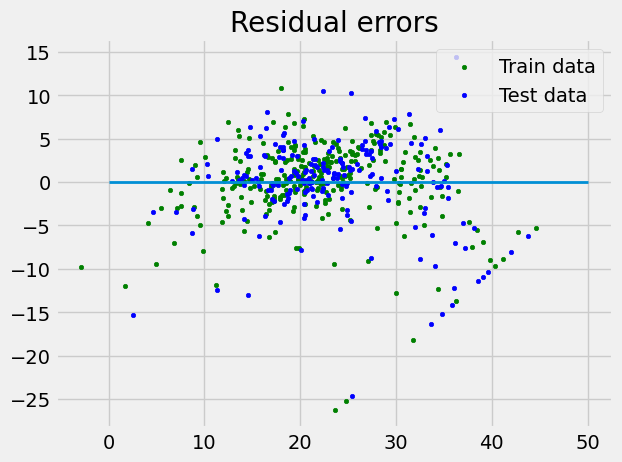

In [12]:
# plot for residual error

# setting plot style
plt.style.use('fivethirtyeight')

# plotting residual errors in training data
plt.scatter(reg.predict(X_train),
            reg.predict(X_train) - y_train,
            color="green", s=10,
            label='Train data')

# plotting residual errors in test data
plt.scatter(reg.predict(X_test),
            reg.predict(X_test) - y_test,
            color="blue", s=10,
            label='Test data')

# plotting line for zero residual error
plt.hlines(y=0, xmin=0, xmax=50, linewidth=2)

# plotting legend
plt.legend(loc='upper right')

# plot title
plt.title("Residual errors")

# method call for showing the plot
plt.show()

In [ ]:
#5. Activation Function
##Reference. https://sanghyu.tistory.com/182

In [16]:
## 1. Sigmoid
import torch
import torch.nn as nn

class DenseBlock(nn.Module):
	def __init__(self, in_dim, out_dim):
		super(DenseBlock, self).__init__()
		self.dense = nn.Linear(in_dim, out_dim)
		self.act = nn.Sigmoid() # activation function

	def forward(self, x):
		out = self.act(self.dense(x))
		return out

In [17]:
## 2. Tanh [Hyperbolic tangent]
import torch
import torch.nn as nn

class DenseBlock(nn.Module):
	def __init__(self, in_dim, out_dim):
		super(DenseBlock, self).__init__()
		self.dense = nn.Linear(in_dim, out_dim)
		self.act = nn.Tanh() # activation function

	def forward(self, x):
		out = self.act(self.dense(x))
		return out

In [ ]:
## 3. ReLU
import torch
import torch.nn as nn

class DenseBlock(nn.Module):
	def __init__(self, in_dim, out_dim):
		super(DenseBlock, self).__init__()
		self.dense = nn.Linear(in_dim, out_dim)
		self.act = nn.ReLU() # activation function

	def forward(self, x):
		out = self.act(self.dense(x))
		return out

In [ ]:
## 4. Leaky ReLU
import torch
import torch.nn as nn

class DenseBlock(nn.Module):
	def __init__(self, in_dim, out_dim):
		super(DenseBlock, self).__init__()
		self.dense = nn.Linear(in_dim, out_dim)
		self.act = nn.LeakyReLU() # activation function

	def forward(self, x):
		out = self.act(self.dense(x))
		return out

In [ ]:
#Question 4.
#Write the code for Maxout, ELU, and GELU in the same format.
#For GELU, please search what GELU is and write your own answer.

In [18]:
## 5. Maxout: 여러 linear function 중에서 최대값을 선택하는 방식
#장점: 유연성, 비선형성, Universal Approximation
import torch
import torch.nn as nn

class DenseBlock(nn.Module):
	def __init__(self, in_dim, out_dim):
		super(DenseBlock, self).__init__()
		self.dense = nn.Linear(in_dim, out_dim)
		self.act = nn.Maxout() # activation function: Maxout

	def forward(self, x):
		out = self.act(self.dense(x))
		return out

In [19]:
## 6. ELU(Exponential Linear Unit): 음수값에 대해 지함수를 사용하여 linear 보다 부드럽게 학
#장점: vanishing gradient problem 해결, bias shift 해결,Relu보다 비연속성 낮음
import torch
import torch.nn as nn

class DenseBlock(nn.Module):
	def __init__(self, in_dim, out_dim):
		super(DenseBlock, self).__init__()
		self.dense = nn.Linear(in_dim, out_dim)
		self.act = nn.ELU() # activation function:ELU

	def forward(self, x):
		out = self.act(self.dense(x))
		return out

In [ ]:
## 7. GELU(Gaussian Error Linear Unit): 정규분포(가우시안 분포)에 따라 확률적 관점을 도입한 활성화함수
#장점: ReLU보다 더 부드러운 approximation, 입력값이 확률적 방식으로 조정되어 자연스러운 학습 가능, q안정적인 gradient descent
import torch
import torch.nn as nn

class DenseBlock(nn.Module):
	def __init__(self, in_dim, out_dim):
		super(DenseBlock, self).__init__()
		self.dense = nn.Linear(in_dim, out_dim)
		self.act = nn.GELU() # activation function: GELU

	def forward(self, x):
		out = self.act(self.dense(x))
		return out